In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet
import xgboost as xgb

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import ks_2samp

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
# upload train dataframe
path = "../../data-256/"
train_df_allsamples = pd.read_csv(path+"train.csv")
train_df_allsamples.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [4]:
# upload train dataframe
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


# TFRecord describes stratified k-fold to keep counts of patient replicates evenly distributed within each fold

Some patients have as many as 115 images - to keep validation more representative of a real testing scenario, training and validation should not share images from the same patient. Furthermore, the number of replicates from each patient should be similar in each fold. The tfrecord column in the data table provides a k-fold partitioning scheme that keeps replicates even distributed in each fold. 

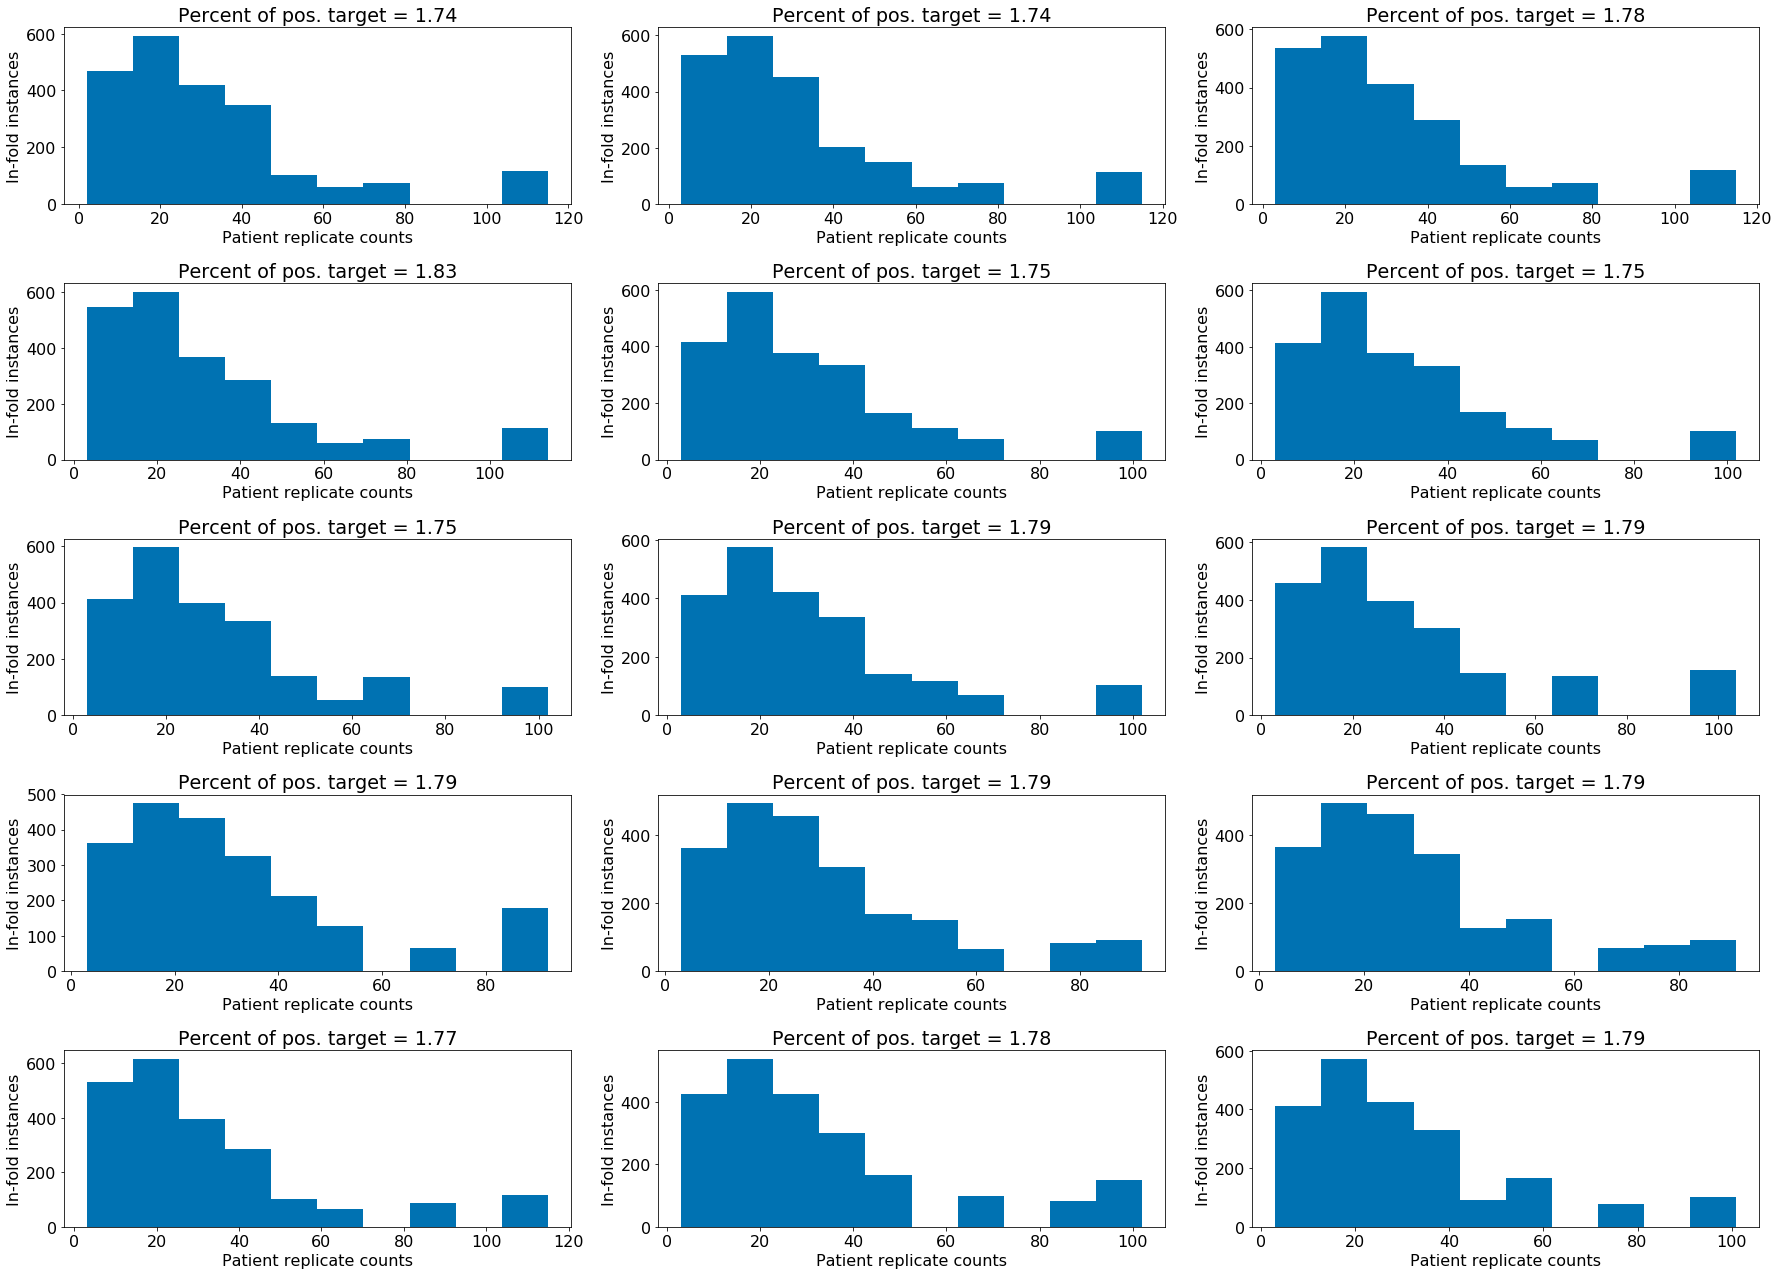

In [5]:
unique_patient_ids, patient_counts = np.unique(train_df_allsamples['patient_id'].values, return_counts=True)
patient_to_count = {p_id:count for p_id, count in zip(unique_patient_ids, patient_counts)}

tfrecords = train_df_allsamples['tfrecord'].values 
folds = np.arange(15)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16,
                     'legend.framealpha':.5,
                     'legend.edgecolor':'k',
                     'axes.edgecolor':'k'})
plt.figure(figsize=(5*5, 6*3))
k = 1 
for f in folds:
    fold_df = train_df_allsamples.iloc[tfrecords == folds[f], :]

    fold_patient_ids = fold_df['patient_id'].values 
    fold_patient_counts = [patient_to_count[p] for p in fold_patient_ids]
    fold_target = fold_df['target'].values
    fold_p_target = 100 * sum(fold_target) / len(fold_target)

    plt.subplot(5, 3, k)
    k += 1
    plt.hist(fold_patient_counts)
    plt.xlabel("Patient replicate counts")
    plt.ylabel("In-fold instances")
    plt.title("Percent of pos. target = {:.2f}".format(fold_p_target))
    
plt.tight_layout()
plt.show()

In [6]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df_allsamples[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform for all images 
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=8),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.ToTensor()])

# additional transform to augment positive samples 
transform_augment_h = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor()])
transform_augment_v = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor()])

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.ToTensor()])  

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform) 
        img_processed = transform_basic(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).

        # load X
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)

        # determine meta data
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])

        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data

    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

def AugmentBatch(images, labels):
    
    # find positives in data set 
    for img, label in zip(images, labels):
        if label == 1:
            # transform image with horizontal flip
            img_aug = transform_augment_h(img).unsqueeze_(0)
            # append set of augmented images and labels 
            images = torch.cat((images, img_aug)) 
            labels = torch.cat((labels, torch.Tensor([label])))
            
            # transform image with vertical flip
            img_aug = transform_augment_v(img).unsqueeze_(0)
            # append set of augmented images and labels 
            images = torch.cat((images, img_aug)) 
            labels = torch.cat((labels, torch.Tensor([label])))

    # shuffle 
    shuffle_inds = torch.randperm(images.size()[0])
    images = images[shuffle_inds, :, :, :]
    labels = labels[shuffle_inds]
    return images, labels

In [7]:
# First, load the EfficientNet with pre-trained parameters 
# ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=512)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.BatchNorm1d(512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.2),
                                    nn.Linear(512, 1),
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

In [8]:
# 2 convolutional layers + 2 fully connected layers 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),  
            nn.Dropout(p=0.4),
            nn.AvgPool2d(kernel_size=4, stride=4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            nn.AvgPool2d(kernel_size=8, stride=8)) 
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4))
        self.output = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #out = self.fc(out)
        return out 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.output(out)
        return out

In [9]:
# weight positive examples more heavily
def make_weights(targets):
    nclasses = len(np.unique(targets))
    count = [0] * nclasses
    for label in targets:
        count[np.int(label)] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(targets)
    for idx, label in enumerate(targets):
        weight[idx] = weight_per_class[np.int(label)]

    return np.array(weight)

# define function to fit and return xgboost model
def fit_xgboost(X_train, y_train, X_val, y_val):

    # weight positive examples more heavily
    w = make_weights(y_train)

    dtrain = xgb.DMatrix(X_train, label=y_train, weight=w)
    dval = xgb.DMatrix(X_val, label=y_val)

    # booster params
    param = {'n_estimators':5000,
            'max_depth':16,
            'learning_rate':0.02,
            'subsample':0.8,
            'eval_metric':'auc',
            'objective': 'binary:logistic',
            'nthread': 8}

    # specify validation set
    evallist = [(dval, 'eval')]

    # Training
    num_round = 5000
    bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=5)

    return bst


Fold [1/15], Epoch [1/16], Step [10/208], ROC AUC: 0.792, Loss: 0.163, K-S stat: 0.603


Fold [1/15], Epoch [1/16], Step [20/208], ROC AUC: 0.848, Loss: 0.099, K-S stat: 0.811


Fold [1/15], Epoch [1/16], Step [30/208], ROC AUC: 0.291, Loss: 0.129, K-S stat: 0.591


Fold [1/15], Epoch [1/16], Step [40/208], ROC AUC: 0.724, Loss: 0.219, K-S stat: 0.664


Fold [1/15], Epoch [1/16], Step [50/208], ROC AUC: 0.681, Loss: 0.181, K-S stat: 0.579


Fold [1/15], Epoch [1/16], Step [60/208], ROC AUC: 0.525, Loss: 0.265, K-S stat: 0.320


Fold [1/15], Epoch [1/16], Step [70/208], ROC AUC: 0.586, Loss: 0.189, K-S stat: 0.460


Fold [1/15], Epoch [1/16], Step [80/208], ROC AUC: 0.995, Loss: 0.097, K-S stat: 0.992


Fold [1/15], Epoch [1/16], Step [90/208], ROC AUC: 0.652, Loss: 0.226, K-S stat: 0.464


Fold [1/15], Epoch [1/16], Step [100/208], ROC AUC: 0.673, Loss: 0.172, K-S stat: 0.603


Fold [1/15], Epoch [1/16], Step [110/208], ROC AUC: 0.492, Loss: 0.409, K-S stat: 0.125


Fold [1/15], Epoch

/opt/conda/conda-bld/pytorch_1587428233860/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



Fold [1/15], Epoch [1/16], Val ROC AUC: 0.815, Val K-S stat: 0.523


Fold [1/15], Epoch [2/16], Step [10/208], ROC AUC: 0.819, Loss: 0.175, K-S stat: 0.651


Fold [1/15], Epoch [2/16], Step [20/208], ROC AUC: 0.697, Loss: 0.182, K-S stat: 0.484


Fold [1/15], Epoch [2/16], Step [40/208], ROC AUC: 0.627, Loss: 0.114, K-S stat: 0.417


Fold [1/15], Epoch [2/16], Step [50/208], ROC AUC: 0.794, Loss: 0.163, K-S stat: 0.627


Fold [1/15], Epoch [2/16], Step [80/208], ROC AUC: 0.628, Loss: 0.191, K-S stat: 0.484


Fold [1/15], Epoch [2/16], Step [90/208], ROC AUC: 0.540, Loss: 0.191, K-S stat: 0.444


Fold [1/15], Epoch [2/16], Step [100/208], ROC AUC: 0.029, Loss: 0.192, K-S stat: 0.961


Fold [1/15], Epoch [2/16], Step [110/208], ROC AUC: 0.754, Loss: 0.226, K-S stat: 0.576


Fold [1/15], Epoch [2/16], Step [120/208], ROC AUC: 0.807, Loss: 0.214, K-S stat: 0.648


Fold [1/15], Epoch [2/16], Step [130/208], ROC AUC: 0.752, Loss: 0.322, K-S stat: 0.437


Fold [1/15], Epoch [2/16], Step [140


Fold [1/15], Epoch [6/16], Step [190/208], ROC AUC: 0.761, Loss: 0.220, K-S stat: 0.432


Fold [1/15], Epoch [6/16], Step [200/208], ROC AUC: 0.557, Loss: 0.212, K-S stat: 0.286


Fold [1/15], Epoch [6/16], Val ROC AUC: 0.824, Val K-S stat: 0.566

Epoch     6: reducing learning rate of group 0 to 1.0000e-05.

Fold [1/15], Epoch [7/16], Step [10/208], ROC AUC: 0.798, Loss: 0.212, K-S stat: 0.536


Fold [1/15], Epoch [7/16], Step [30/208], ROC AUC: 0.700, Loss: 0.229, K-S stat: 0.370


Fold [1/15], Epoch [7/16], Step [40/208], ROC AUC: 0.838, Loss: 0.225, K-S stat: 0.621


Fold [1/15], Epoch [7/16], Step [50/208], ROC AUC: 0.931, Loss: 0.179, K-S stat: 0.824


Fold [1/15], Epoch [7/16], Step [60/208], ROC AUC: 0.850, Loss: 0.109, K-S stat: 0.835


Fold [1/15], Epoch [7/16], Step [70/208], ROC AUC: 0.963, Loss: 0.097, K-S stat: 0.953


Fold [1/15], Epoch [7/16], Step [80/208], ROC AUC: 0.917, Loss: 0.140, K-S stat: 0.730


Fold [1/15], Epoch [7/16], Step [90/208], ROC AUC: 0.575, Loss: 0

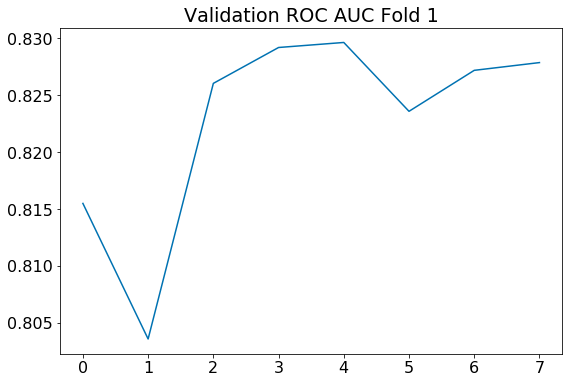


Fold [2/15], Epoch [1/16], Step [10/208], ROC AUC: 0.873, Loss: 0.352, K-S stat: 0.705


Fold [2/15], Epoch [1/16], Step [20/208], ROC AUC: 0.645, Loss: 0.236, K-S stat: 0.536


Fold [2/15], Epoch [1/16], Step [30/208], ROC AUC: 0.783, Loss: 0.160, K-S stat: 0.524


Fold [2/15], Epoch [1/16], Step [40/208], ROC AUC: 0.661, Loss: 0.143, K-S stat: 0.583


Fold [2/15], Epoch [1/16], Step [50/208], ROC AUC: 0.803, Loss: 0.227, K-S stat: 0.578


Fold [2/15], Epoch [1/16], Step [60/208], ROC AUC: 0.740, Loss: 0.238, K-S stat: 0.459


Fold [2/15], Epoch [1/16], Step [70/208], ROC AUC: 0.786, Loss: 0.156, K-S stat: 0.698


Fold [2/15], Epoch [1/16], Step [80/208], ROC AUC: 0.897, Loss: 0.138, K-S stat: 0.778


Fold [2/15], Epoch [1/16], Step [90/208], ROC AUC: 0.892, Loss: 0.136, K-S stat: 0.802


Fold [2/15], Epoch [1/16], Step [100/208], ROC AUC: 0.942, Loss: 0.173, K-S stat: 0.913


Fold [2/15], Epoch [1/16], Step [110/208], ROC AUC: 0.541, Loss: 0.196, K-S stat: 0.294


Fold [2/15], Epoch


Fold [2/15], Epoch [5/16], Step [140/208], ROC AUC: 0.778, Loss: 0.201, K-S stat: 0.552


Fold [2/15], Epoch [5/16], Step [150/208], ROC AUC: 0.845, Loss: 0.143, K-S stat: 0.603


Fold [2/15], Epoch [5/16], Step [160/208], ROC AUC: 0.911, Loss: 0.222, K-S stat: 0.699


Fold [2/15], Epoch [5/16], Step [170/208], ROC AUC: 0.812, Loss: 0.200, K-S stat: 0.505


Fold [2/15], Epoch [5/16], Step [180/208], ROC AUC: 0.912, Loss: 0.270, K-S stat: 0.748


Fold [2/15], Epoch [5/16], Step [190/208], ROC AUC: 0.737, Loss: 0.286, K-S stat: 0.460


Fold [2/15], Epoch [5/16], Step [200/208], ROC AUC: 0.879, Loss: 0.103, K-S stat: 0.756


Fold [2/15], Epoch [5/16], Val ROC AUC: 0.818, Val K-S stat: 0.518

Epoch     5: reducing learning rate of group 0 to 1.0000e-05.

Fold [2/15], Epoch [6/16], Step [10/208], ROC AUC: 0.903, Loss: 0.172, K-S stat: 0.712


Fold [2/15], Epoch [6/16], Step [20/208], ROC AUC: 0.906, Loss: 0.139, K-S stat: 0.810


Fold [2/15], Epoch [6/16], Step [30/208], ROC AUC: 0.864, Lo


Fold [2/15], Epoch [10/16], Step [120/208], ROC AUC: 0.810, Loss: 0.159, K-S stat: 0.603


Fold [2/15], Epoch [10/16], Step [130/208], ROC AUC: 0.879, Loss: 0.188, K-S stat: 0.688


Fold [2/15], Epoch [10/16], Step [140/208], ROC AUC: 0.900, Loss: 0.173, K-S stat: 0.704


Fold [2/15], Epoch [10/16], Step [150/208], ROC AUC: 0.856, Loss: 0.098, K-S stat: 0.772


Fold [2/15], Epoch [10/16], Step [160/208], ROC AUC: 0.995, Loss: 0.076, K-S stat: 0.992


Fold [2/15], Epoch [10/16], Step [170/208], ROC AUC: 0.795, Loss: 0.154, K-S stat: 0.508


Fold [2/15], Epoch [10/16], Step [190/208], ROC AUC: 0.866, Loss: 0.099, K-S stat: 0.803


Fold [2/15], Epoch [10/16], Step [200/208], ROC AUC: 0.724, Loss: 0.290, K-S stat: 0.401


Fold [2/15], Epoch [10/16], Val ROC AUC: 0.823, Val K-S stat: 0.528


Fold [2/15], Epoch [11/16], Step [10/208], ROC AUC: 0.701, Loss: 0.355, K-S stat: 0.348


Fold [2/15], Epoch [11/16], Step [20/208], ROC AUC: 0.877, Loss: 0.141, K-S stat: 0.683


Fold [2/15], Epoch [1


Fold [2/15], Epoch [15/16], Step [20/208], ROC AUC: 0.640, Loss: 0.192, K-S stat: 0.317


Fold [2/15], Epoch [15/16], Step [30/208], ROC AUC: 0.937, Loss: 0.129, K-S stat: 0.802


Fold [2/15], Epoch [15/16], Step [40/208], ROC AUC: 0.963, Loss: 0.119, K-S stat: 0.921


Fold [2/15], Epoch [15/16], Step [50/208], ROC AUC: 0.884, Loss: 0.227, K-S stat: 0.608


Fold [2/15], Epoch [15/16], Step [60/208], ROC AUC: 0.803, Loss: 0.107, K-S stat: 0.622


Fold [2/15], Epoch [15/16], Step [70/208], ROC AUC: 0.921, Loss: 0.211, K-S stat: 0.806


Fold [2/15], Epoch [15/16], Step [90/208], ROC AUC: 0.898, Loss: 0.127, K-S stat: 0.730


Fold [2/15], Epoch [15/16], Step [100/208], ROC AUC: 0.826, Loss: 0.207, K-S stat: 0.584


Fold [2/15], Epoch [15/16], Step [110/208], ROC AUC: 0.636, Loss: 0.252, K-S stat: 0.464


Fold [2/15], Epoch [15/16], Step [130/208], ROC AUC: 0.932, Loss: 0.088, K-S stat: 0.898


Fold [2/15], Epoch [15/16], Step [140/208], ROC AUC: 0.966, Loss: 0.119, K-S stat: 0.937


Fold 

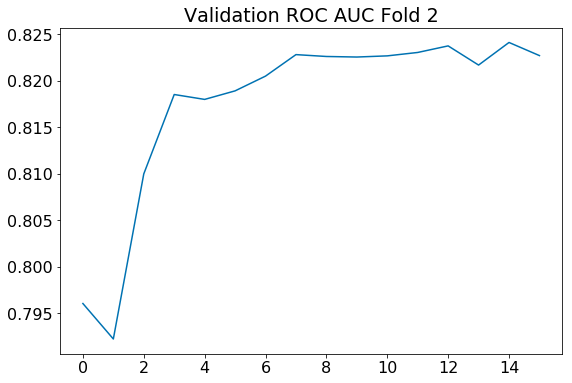


Fold [3/15], Epoch [1/16], Step [10/208], ROC AUC: 0.969, Loss: 0.069, K-S stat: 0.961


Fold [3/15], Epoch [1/16], Step [20/208], ROC AUC: 0.703, Loss: 0.144, K-S stat: 0.638


Fold [3/15], Epoch [1/16], Step [30/208], ROC AUC: 0.942, Loss: 0.139, K-S stat: 0.873


Fold [3/15], Epoch [1/16], Step [40/208], ROC AUC: 0.932, Loss: 0.173, K-S stat: 0.784


Fold [3/15], Epoch [1/16], Step [50/208], ROC AUC: 0.676, Loss: 0.194, K-S stat: 0.468


Fold [3/15], Epoch [1/16], Step [60/208], ROC AUC: 0.791, Loss: 0.163, K-S stat: 0.516


Fold [3/15], Epoch [1/16], Step [70/208], ROC AUC: 0.624, Loss: 0.261, K-S stat: 0.347


Fold [3/15], Epoch [1/16], Step [80/208], ROC AUC: 0.850, Loss: 0.095, K-S stat: 0.772


Fold [3/15], Epoch [1/16], Step [90/208], ROC AUC: 0.784, Loss: 0.218, K-S stat: 0.522


Fold [3/15], Epoch [1/16], Step [100/208], ROC AUC: 0.661, Loss: 0.134, K-S stat: 0.591


Fold [3/15], Epoch [1/16], Step [110/208], ROC AUC: 0.458, Loss: 0.230, K-S stat: 0.333


Fold [3/15], Epoch


Fold [3/15], Epoch [5/16], Step [180/208], ROC AUC: 0.827, Loss: 0.154, K-S stat: 0.563


Fold [3/15], Epoch [5/16], Step [190/208], ROC AUC: 0.768, Loss: 0.223, K-S stat: 0.466


Fold [3/15], Epoch [5/16], Step [200/208], ROC AUC: 0.974, Loss: 0.087, K-S stat: 0.961


Fold [3/15], Epoch [5/16], Val ROC AUC: 0.809, Val K-S stat: 0.506


Fold [3/15], Epoch [6/16], Step [10/208], ROC AUC: 0.958, Loss: 0.087, K-S stat: 0.913


Fold [3/15], Epoch [6/16], Step [20/208], ROC AUC: 0.436, Loss: 0.134, K-S stat: 0.409


Fold [3/15], Epoch [6/16], Step [30/208], ROC AUC: 0.897, Loss: 0.175, K-S stat: 0.698


Fold [3/15], Epoch [6/16], Step [40/208], ROC AUC: 0.881, Loss: 0.225, K-S stat: 0.664


Fold [3/15], Epoch [6/16], Step [50/208], ROC AUC: 0.927, Loss: 0.089, K-S stat: 0.843


Fold [3/15], Epoch [6/16], Step [60/208], ROC AUC: 0.672, Loss: 0.315, K-S stat: 0.384


Fold [3/15], Epoch [6/16], Step [70/208], ROC AUC: 0.881, Loss: 0.144, K-S stat: 0.738


Fold [3/15], Epoch [6/16], Step [80/2


Fold [3/15], Epoch [10/16], Step [120/208], ROC AUC: 0.919, Loss: 0.130, K-S stat: 0.817


Fold [3/15], Epoch [10/16], Step [130/208], ROC AUC: 0.947, Loss: 0.124, K-S stat: 0.810


Fold [3/15], Epoch [10/16], Step [140/208], ROC AUC: 0.719, Loss: 0.112, K-S stat: 0.622


Fold [3/15], Epoch [10/16], Step [150/208], ROC AUC: 0.884, Loss: 0.132, K-S stat: 0.659


Fold [3/15], Epoch [10/16], Step [160/208], ROC AUC: 0.875, Loss: 0.225, K-S stat: 0.659


Fold [3/15], Epoch [10/16], Step [170/208], ROC AUC: 0.798, Loss: 0.162, K-S stat: 0.595


Fold [3/15], Epoch [10/16], Step [180/208], ROC AUC: 0.882, Loss: 0.097, K-S stat: 0.661


Fold [3/15], Epoch [10/16], Step [200/208], ROC AUC: 0.836, Loss: 0.298, K-S stat: 0.633


Fold [3/15], Epoch [10/16], Val ROC AUC: 0.812, Val K-S stat: 0.504


Fold [3/15], Epoch [11/16], Step [10/208], ROC AUC: 0.969, Loss: 0.081, K-S stat: 0.945


Fold [3/15], Epoch [11/16], Step [20/208], ROC AUC: 0.987, Loss: 0.079, K-S stat: 0.976


Fold [3/15], Epoch [1


Fold [3/15], Epoch [15/16], Step [70/208], ROC AUC: 0.858, Loss: 0.102, K-S stat: 0.764


Fold [3/15], Epoch [15/16], Step [80/208], ROC AUC: 0.921, Loss: 0.135, K-S stat: 0.857


Fold [3/15], Epoch [15/16], Step [90/208], ROC AUC: 0.709, Loss: 0.112, K-S stat: 0.638


Fold [3/15], Epoch [15/16], Step [100/208], ROC AUC: 0.874, Loss: 0.101, K-S stat: 0.795


Fold [3/15], Epoch [15/16], Step [110/208], ROC AUC: 0.739, Loss: 0.174, K-S stat: 0.524


Fold [3/15], Epoch [15/16], Step [120/208], ROC AUC: 0.840, Loss: 0.104, K-S stat: 0.693


Fold [3/15], Epoch [15/16], Step [130/208], ROC AUC: 0.937, Loss: 0.091, K-S stat: 0.843


Fold [3/15], Epoch [15/16], Step [140/208], ROC AUC: 0.768, Loss: 0.217, K-S stat: 0.489


Fold [3/15], Epoch [15/16], Step [150/208], ROC AUC: 0.856, Loss: 0.235, K-S stat: 0.640


Fold [3/15], Epoch [15/16], Step [160/208], ROC AUC: 0.924, Loss: 0.161, K-S stat: 0.752


Fold [3/15], Epoch [15/16], Step [170/208], ROC AUC: 0.661, Loss: 0.123, K-S stat: 0.630


F

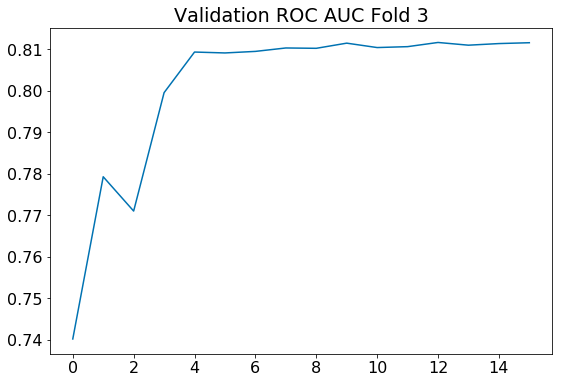


Fold [4/15], Epoch [1/16], Step [10/208], ROC AUC: 0.489, Loss: 0.530, K-S stat: 0.250


Fold [4/15], Epoch [1/16], Step [20/208], ROC AUC: 0.843, Loss: 0.110, K-S stat: 0.772


Fold [4/15], Epoch [1/16], Step [40/208], ROC AUC: 0.776, Loss: 0.165, K-S stat: 0.556


Fold [4/15], Epoch [1/16], Step [50/208], ROC AUC: 0.771, Loss: 0.209, K-S stat: 0.616


Fold [4/15], Epoch [1/16], Step [60/208], ROC AUC: 0.683, Loss: 0.288, K-S stat: 0.435


Fold [4/15], Epoch [1/16], Step [70/208], ROC AUC: 0.718, Loss: 0.172, K-S stat: 0.540


Fold [4/15], Epoch [1/16], Step [80/208], ROC AUC: 0.735, Loss: 0.107, K-S stat: 0.583


Fold [4/15], Epoch [1/16], Step [90/208], ROC AUC: 0.698, Loss: 0.191, K-S stat: 0.429


Fold [4/15], Epoch [1/16], Step [110/208], ROC AUC: 0.423, Loss: 0.126, K-S stat: 0.465


Fold [4/15], Epoch [1/16], Step [120/208], ROC AUC: 0.853, Loss: 0.162, K-S stat: 0.667


Fold [4/15], Epoch [1/16], Step [130/208], ROC AUC: 0.982, Loss: 0.094, K-S stat: 0.945


Fold [4/15], Epoc


Fold [4/15], Epoch [5/16], Step [160/208], ROC AUC: 0.950, Loss: 0.121, K-S stat: 0.833


Fold [4/15], Epoch [5/16], Step [170/208], ROC AUC: 0.741, Loss: 0.224, K-S stat: 0.434


Fold [4/15], Epoch [5/16], Step [180/208], ROC AUC: 0.825, Loss: 0.148, K-S stat: 0.548


Fold [4/15], Epoch [5/16], Step [190/208], ROC AUC: 0.995, Loss: 0.076, K-S stat: 0.992


Fold [4/15], Epoch [5/16], Step [200/208], ROC AUC: 0.962, Loss: 0.119, K-S stat: 0.825


Fold [4/15], Epoch [5/16], Val ROC AUC: 0.789, Val K-S stat: 0.449


Fold [4/15], Epoch [6/16], Step [10/208], ROC AUC: 0.638, Loss: 0.193, K-S stat: 0.389


Fold [4/15], Epoch [6/16], Step [20/208], ROC AUC: 0.885, Loss: 0.096, K-S stat: 0.819


Fold [4/15], Epoch [6/16], Step [30/208], ROC AUC: 0.766, Loss: 0.107, K-S stat: 0.740


Fold [4/15], Epoch [6/16], Step [40/208], ROC AUC: 0.969, Loss: 0.082, K-S stat: 0.945


Fold [4/15], Epoch [6/16], Step [70/208], ROC AUC: 0.597, Loss: 0.195, K-S stat: 0.413


Fold [4/15], Epoch [6/16], Step [80


Fold [4/15], Epoch [10/16], Step [100/208], ROC AUC: 0.858, Loss: 0.225, K-S stat: 0.702


Fold [4/15], Epoch [10/16], Step [110/208], ROC AUC: 0.921, Loss: 0.137, K-S stat: 0.786


Fold [4/15], Epoch [10/16], Step [120/208], ROC AUC: 0.866, Loss: 0.147, K-S stat: 0.698


Fold [4/15], Epoch [10/16], Step [130/208], ROC AUC: 0.944, Loss: 0.131, K-S stat: 0.881


Fold [4/15], Epoch [10/16], Step [140/208], ROC AUC: 0.942, Loss: 0.087, K-S stat: 0.850


Fold [4/15], Epoch [10/16], Step [160/208], ROC AUC: 0.953, Loss: 0.091, K-S stat: 0.882


Fold [4/15], Epoch [10/16], Step [170/208], ROC AUC: 0.868, Loss: 0.189, K-S stat: 0.760


Fold [4/15], Epoch [10/16], Step [180/208], ROC AUC: 0.817, Loss: 0.300, K-S stat: 0.659


Fold [4/15], Epoch [10/16], Step [200/208], ROC AUC: 0.728, Loss: 0.175, K-S stat: 0.524


Fold [4/15], Epoch [10/16], Val ROC AUC: 0.791, Val K-S stat: 0.451


Fold [4/15], Epoch [11/16], Step [10/208], ROC AUC: 0.788, Loss: 0.327, K-S stat: 0.449


Fold [4/15], Epoch [


Fold [4/15], Epoch [15/16], Step [100/208], ROC AUC: 0.906, Loss: 0.094, K-S stat: 0.890


Fold [4/15], Epoch [15/16], Step [110/208], ROC AUC: 0.932, Loss: 0.092, K-S stat: 0.866


Fold [4/15], Epoch [15/16], Step [120/208], ROC AUC: 0.851, Loss: 0.244, K-S stat: 0.691


Fold [4/15], Epoch [15/16], Step [130/208], ROC AUC: 0.717, Loss: 0.168, K-S stat: 0.500


Fold [4/15], Epoch [15/16], Step [140/208], ROC AUC: 0.775, Loss: 0.158, K-S stat: 0.556


Fold [4/15], Epoch [15/16], Step [150/208], ROC AUC: 0.868, Loss: 0.191, K-S stat: 0.682


Fold [4/15], Epoch [15/16], Step [160/208], ROC AUC: 0.848, Loss: 0.177, K-S stat: 0.656


Fold [4/15], Epoch [15/16], Step [180/208], ROC AUC: 0.778, Loss: 0.279, K-S stat: 0.554


Fold [4/15], Epoch [15/16], Step [190/208], ROC AUC: 0.801, Loss: 0.106, K-S stat: 0.724


Fold [4/15], Epoch [15/16], Step [200/208], ROC AUC: 0.701, Loss: 0.173, K-S stat: 0.579


Fold [4/15], Epoch [15/16], Val ROC AUC: 0.791, Val K-S stat: 0.445


Fold [4/15], Epoch 

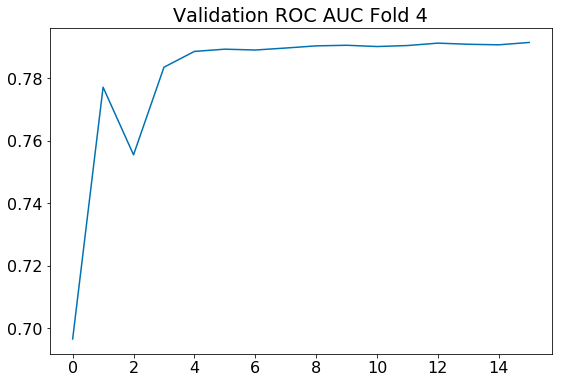


Fold [5/15], Epoch [1/16], Step [10/208], ROC AUC: 0.576, Loss: 0.282, K-S stat: 0.424


Fold [5/15], Epoch [1/16], Step [20/208], ROC AUC: 0.766, Loss: 0.164, K-S stat: 0.627


Fold [5/15], Epoch [1/16], Step [30/208], ROC AUC: 0.596, Loss: 0.128, K-S stat: 0.528


Fold [5/15], Epoch [1/16], Step [50/208], ROC AUC: 0.571, Loss: 0.449, K-S stat: 0.250


Fold [5/15], Epoch [1/16], Step [60/208], ROC AUC: 0.739, Loss: 0.297, K-S stat: 0.452


Fold [5/15], Epoch [1/16], Step [70/208], ROC AUC: 0.545, Loss: 0.203, K-S stat: 0.198


Fold [5/15], Epoch [1/16], Step [80/208], ROC AUC: 0.803, Loss: 0.162, K-S stat: 0.611


Fold [5/15], Epoch [1/16], Step [110/208], ROC AUC: 0.775, Loss: 0.294, K-S stat: 0.585


Fold [5/15], Epoch [1/16], Step [120/208], ROC AUC: 0.824, Loss: 0.100, K-S stat: 0.780


Fold [5/15], Epoch [1/16], Step [130/208], ROC AUC: 0.650, Loss: 0.374, K-S stat: 0.426


Fold [5/15], Epoch [1/16], Step [140/208], ROC AUC: 0.629, Loss: 0.252, K-S stat: 0.384


Fold [5/15], Epo


Fold [5/15], Epoch [6/16], Step [30/208], ROC AUC: 0.714, Loss: 0.226, K-S stat: 0.380


Fold [5/15], Epoch [6/16], Step [40/208], ROC AUC: 0.866, Loss: 0.099, K-S stat: 0.858


Fold [5/15], Epoch [6/16], Step [50/208], ROC AUC: 0.862, Loss: 0.145, K-S stat: 0.683


Fold [5/15], Epoch [6/16], Step [60/208], ROC AUC: 0.783, Loss: 0.272, K-S stat: 0.538


Fold [5/15], Epoch [6/16], Step [70/208], ROC AUC: 0.780, Loss: 0.167, K-S stat: 0.619


Fold [5/15], Epoch [6/16], Step [90/208], ROC AUC: 0.588, Loss: 0.274, K-S stat: 0.218


Fold [5/15], Epoch [6/16], Step [100/208], ROC AUC: 0.916, Loss: 0.336, K-S stat: 0.795


Fold [5/15], Epoch [6/16], Step [110/208], ROC AUC: 0.945, Loss: 0.090, K-S stat: 0.890


Fold [5/15], Epoch [6/16], Step [120/208], ROC AUC: 0.895, Loss: 0.093, K-S stat: 0.701


Fold [5/15], Epoch [6/16], Step [160/208], ROC AUC: 0.795, Loss: 0.109, K-S stat: 0.724


Fold [5/15], Epoch [6/16], Step [170/208], ROC AUC: 0.784, Loss: 0.157, K-S stat: 0.627


Fold [5/15], Ep


Fold [5/15], Epoch [11/16], Step [60/208], ROC AUC: 0.982, Loss: 0.083, K-S stat: 0.976


Fold [5/15], Epoch [11/16], Step [70/208], ROC AUC: 0.809, Loss: 0.309, K-S stat: 0.610


Fold [5/15], Epoch [11/16], Step [80/208], ROC AUC: 0.715, Loss: 0.339, K-S stat: 0.354


Fold [5/15], Epoch [11/16], Step [90/208], ROC AUC: 0.940, Loss: 0.093, K-S stat: 0.906


Fold [5/15], Epoch [11/16], Step [100/208], ROC AUC: 0.892, Loss: 0.098, K-S stat: 0.858


Fold [5/15], Epoch [11/16], Step [110/208], ROC AUC: 0.724, Loss: 0.228, K-S stat: 0.587


Fold [5/15], Epoch [11/16], Step [120/208], ROC AUC: 0.724, Loss: 0.108, K-S stat: 0.606


Fold [5/15], Epoch [11/16], Step [130/208], ROC AUC: 0.835, Loss: 0.104, K-S stat: 0.819


Fold [5/15], Epoch [11/16], Step [140/208], ROC AUC: 0.681, Loss: 0.181, K-S stat: 0.444


Fold [5/15], Epoch [11/16], Step [150/208], ROC AUC: 0.830, Loss: 0.294, K-S stat: 0.699


Fold [5/15], Epoch [11/16], Step [180/208], ROC AUC: 0.929, Loss: 0.093, K-S stat: 0.850


Fo


Fold [5/15], Epoch [16/16], Step [40/208], ROC AUC: 0.822, Loss: 0.198, K-S stat: 0.577


Fold [5/15], Epoch [16/16], Step [50/208], ROC AUC: 0.630, Loss: 0.253, K-S stat: 0.416


Fold [5/15], Epoch [16/16], Step [60/208], ROC AUC: 0.976, Loss: 0.082, K-S stat: 0.969


Fold [5/15], Epoch [16/16], Step [90/208], ROC AUC: 0.873, Loss: 0.238, K-S stat: 0.694


Fold [5/15], Epoch [16/16], Step [100/208], ROC AUC: 0.917, Loss: 0.142, K-S stat: 0.857


Fold [5/15], Epoch [16/16], Step [110/208], ROC AUC: 0.921, Loss: 0.093, K-S stat: 0.890


Fold [5/15], Epoch [16/16], Step [120/208], ROC AUC: 0.801, Loss: 0.212, K-S stat: 0.688


Fold [5/15], Epoch [16/16], Step [130/208], ROC AUC: 0.982, Loss: 0.087, K-S stat: 0.976


Fold [5/15], Epoch [16/16], Step [160/208], ROC AUC: 0.840, Loss: 0.150, K-S stat: 0.698


Fold [5/15], Epoch [16/16], Step [170/208], ROC AUC: 0.886, Loss: 0.296, K-S stat: 0.699


Fold [5/15], Epoch [16/16], Step [180/208], ROC AUC: 0.759, Loss: 0.215, K-S stat: 0.452


Fo

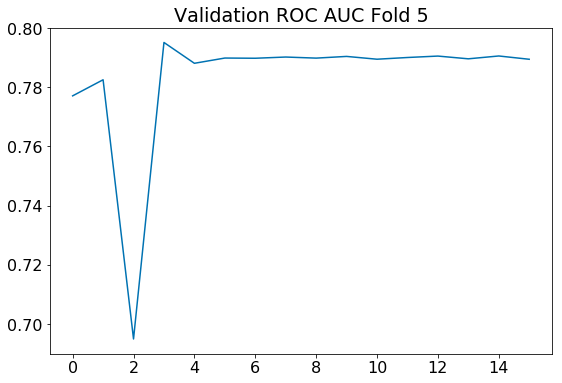

In [10]:
# Train the model
# Use the prebuilt data loader.
train_path = path + "train/"
test_path = path + "test/"
path_to_model = '../Models/model.ckpt'

# define batch size and accumulation steps 
num_epochs = 16
batchsize  = 128
accumulation_steps = 1 # ~ sort of like making an effective batchsize = acc.steps * batchsize ? 
evaluation_steps = 10
set_patience = 3 
best_val     = 0
verbose = True
        
# record out-of-fold predictions and test predictions 
nn_oof = np.zeros(len(train_df_allsamples))
xgb_oof = np.zeros(len(train_df_allsamples))
nn_predictions = np.zeros(len(test_df))
xgb_predictions = np.zeros(len(test_df))

# create a test loader 
test_dataset = TestDataset(test_df, test_path)                                              
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize) 

# update folds to 5 sets of inds 
fold_sets = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 13, 14]]

# loop through every fold 
for f, fold_set in enumerate(fold_sets):
    # initialize new model for each fold 
    # model = MyENet(ENet).to(device)
    model = ConvNet().to(device)
    
    # define lr and optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    # scheduler reduces learning rate by factor of 10 when val auc does not improve
    scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=3e-6, mode='max', patience=0, verbose=True)
    
    # pull the training and validation data for each fold
    inds = np.in1d(tfrecords, np.array(fold_set))
    train_df = train_df_allsamples.iloc[~inds, :]
    val_df = train_df_allsamples.iloc[inds, :]

    # evaluate performance on validation data 
    train_dataset = TrainDataset(train_df, train_path)                                              
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True) 
    
    # evaluate performance on validation data 
    valid_dataset = ValidDataset(val_df, train_path)                                              
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batchsize, shuffle=False) 
    
    # save validation statistics 
    val_roc = []
    val_ks_stat = []
    
    # Reset gradients
    for epoch in range(num_epochs):
        
        # set up model for training     
        model.train()
        for i, (images, meta_data, labels) in enumerate(train_loader):

            # augment the batch with more positive samples 
            images, labels = AugmentBatch(images, labels)
            
            # send images and labels to gpu or cpu RAM 
            images = images.to(device)
            labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)   
            
            # Compute loss 
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps                # Normalize loss (if averaged)
            loss.backward()                                 # Backward pass
            if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
                optimizer.step()                            # Now we can do an optimizer step
                model.zero_grad()                           # Reset gradients tensors
            
            # calculate performance 
            train_targets = np.array(labels.cpu().numpy(), np.int)
            train_predictions = outputs.detach().cpu().numpy().ravel()

            # if positive samples existed in batch 
            if sum(train_targets)[0] > 0:
                fpr, tpr, _ = roc_curve(train_targets, train_predictions)
                roc = auc(fpr, tpr)
                
                ks_stat, p = ks_2samp(np.array(train_predictions).ravel()[np.array(train_targets).ravel()==0], 
                                   np.array(train_predictions).ravel()[np.array(train_targets).ravel()==1])

                if verbose and (i+1) % evaluation_steps == 0:
                    # Print performance on minibatch train data 
                    print ('\nFold [{}/{}], Epoch [{}/{}], Step [{}/{}], ROC AUC: {:.3f}, Loss: {:.3f}, K-S stat: {:.3f}\n'
                       .format(f+1, len(fold_sets), epoch+1, num_epochs, i+1, len(train_loader), roc, loss.detach().cpu().numpy(), ks_stat))
                
        
        # Evaluate validation data at end of each epoch
        valid_predictions = []
        valid_targets = []
        model.eval() 
        with torch.no_grad():
            for j, (images, meta_data, labels) in enumerate(valid_loader):
                images = images.to(device)

                labels = torch.reshape(labels, [len(labels), 1])
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate val ROC
                valid_predictions += list(outputs.detach().cpu().numpy())
                valid_targets += list(labels.cpu().numpy())

        # Calculate performance statistics on validation data 
        fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
        val_roc_epoch = auc(fpr, tpr)
        val_roc.append(val_roc_epoch)
        val_ks_stat_epoch, p = ks_2samp(np.array(valid_predictions).ravel()[np.array(valid_targets).ravel()==0], 
                                        np.array(valid_predictions).ravel()[np.array(valid_targets).ravel()==1])
        val_ks_stat.append(val_ks_stat_epoch)

        print('\nFold [{}/{}], Epoch [{}/{}], Val ROC AUC: {:.3f}, Val K-S stat: {:.3f}\n'
               .format(f+1, len(fold_sets), epoch+1, num_epochs, val_roc_epoch, val_ks_stat_epoch))

        # learning rate is reduced if val roc doesn't improve 
        scheduler.step(val_roc_epoch)
        
        if val_roc_epoch > best_val:
            best_val = val_roc_epoch
            patience = set_patience        
            torch.save(model.state_dict(), path_to_model)  
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best validation roc_auc: {:.3f}'.format(best_val))
                model.load_state_dict(torch.load(path_to_model), strict=False)
                break

    # Load best model from fold 
    model.load_state_dict(torch.load(path_to_model))
    
    # at the end of fold, use model to create new training data set 
    model.eval()
    
    print("Creating training data for xgb model")
    X_train = []
    y_train = []
    for i, (images, meta_data, labels) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model(images).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)

        # append the dataset
        X_train.append(batch_features)
        y_train.append(labels.numpy())

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    print("Creating validation data for xgb model")
    X_valid = []
    y_valid = []
    for i, (images, meta_data, labels) in enumerate(valid_loader):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model(images).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)

        # append the dataset
        X_valid.append(batch_features)
        y_valid.append(labels.numpy())

    X_valid = np.concatenate(X_valid, axis=0)
    y_valid = np.concatenate(y_valid, axis=0) 
    
    print("Creating testing data for xgb model")
    X_test = []
    for i, (images, meta_data) in enumerate(test_loader):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model(images).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)

        # append the dataset
        X_test.append(batch_features)

    X_test = np.concatenate(X_test, axis=0)
    
    # standardize training and validation data sets 
    mean_X = np.nanmean(X_train, 0)
    std_X = np.nanstd(X_train, 0)

    # standardize training data set
    X_train_std = (X_train - mean_X) / std_X
    
    # standardize validation data set 
    X_valid_std = (X_valid - mean_X) / std_X
    
    # standardize test data set 
    X_test_std = (X_test - mean_X) / std_X 
    
    # train xgboost
    bst = fit_xgboost(X_train_std, y_train, X_valid_std, y_valid)
    
    # save out of fold predictions
    y_valid_pred = bst.predict(xgb.DMatrix(X_valid_std))
    xgb_oof[inds] += y_valid_pred
    nn_oof[inds] += X_valid[:, -1]

    # save test predictions 
    xgb_predictions += bst.predict(xgb.DMatrix(X_test_std)) / len(fold_sets)
    nn_predictions += X_test[:, -1] / len(fold_sets)
    
    # Calculate performance statistics on validation data 
    fpr, tpr, _ = roc_curve(y_valid, y_valid_pred)
    val_roc_xgb = auc(fpr, tpr)
    val_ks_xgb, p = ks_2samp(y_valid_pred[y_valid==0], 
                             y_valid_pred[y_valid==1])

    print('\nFold [{}/{}], XGB Val ROC AUC: {:.3f}, XGB Val K-S stat: {:.3f}\n'
           .format(f+1, len(fold_sets), val_roc_xgb, val_ks_xgb))
    
    plt.style.use('seaborn-colorblind')
    plt.rcParams.update({'font.size': 16, 
                         'legend.framealpha':1, 
                         'legend.edgecolor':'inherit'}) 
    plt.figure(figsize=(9, 6))

    plt.plot(val_roc)
    plt.title("Validation ROC AUC Fold {}".format(f+1))
    plt.show()

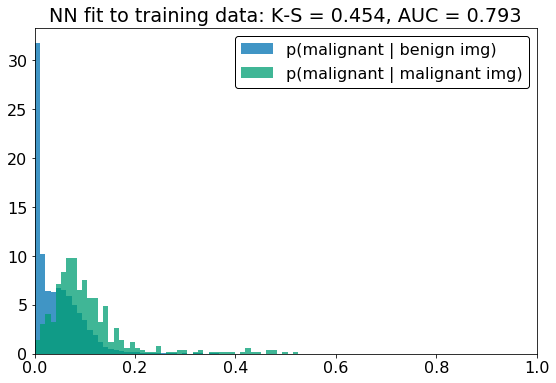

In [11]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

nn_train_predictions = X_train[:, -1]

counts, bins = np.histogram(np.array(nn_train_predictions), bins=50)
plt.hist(nn_train_predictions[y_train==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(nn_train_predictions[y_train==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(nn_train_predictions[y_train==0], 
                          nn_train_predictions[y_train==1])
fpr, tpr, _ = roc_curve(y_train, nn_train_predictions)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("NN fit to training data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

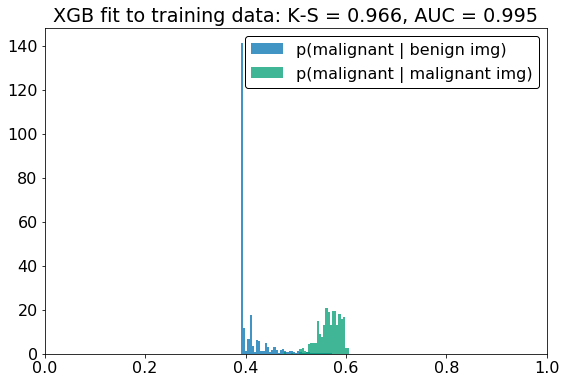

In [12]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

train_predictions = bst.predict(xgb.DMatrix(X_train_std))

counts, bins = np.histogram(np.array(train_predictions), bins=50)
plt.hist(train_predictions[y_train==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(train_predictions[y_train==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(train_predictions[y_train==0], 
                           train_predictions[y_train==1])
fpr, tpr, _ = roc_curve(y_train, train_predictions)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("XGB fit to training data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

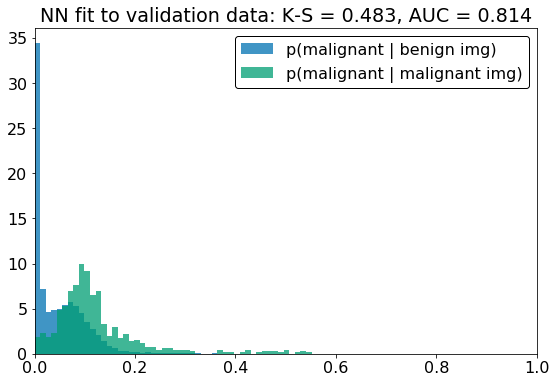

In [13]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

valid_pred = nn_oof
y_valid = train_df_allsamples['target'].values

counts, bins = np.histogram(np.array(valid_pred), bins=50)
plt.hist(valid_pred[y_valid==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(valid_pred[y_valid==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(valid_pred[y_valid==0], 
                 valid_pred[y_valid==1])

fpr, tpr, _ = roc_curve(y_valid, valid_pred)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("NN fit to validation data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

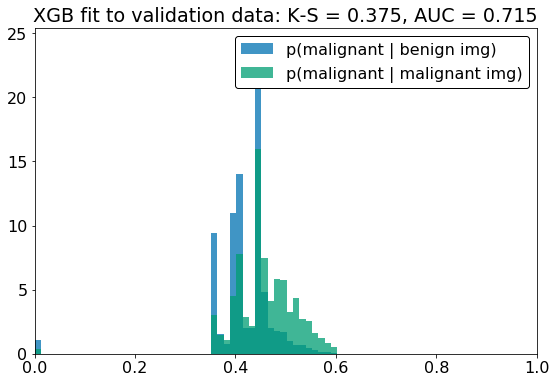

In [14]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

valid_pred = xgb_oof
y_valid = train_df_allsamples['target'].values

counts, bins = np.histogram(np.array(valid_pred), bins=50)
plt.hist(valid_pred[y_valid==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(valid_pred[y_valid==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(valid_pred[y_valid==0], 
                 valid_pred[y_valid==1])

fpr, tpr, _ = roc_curve(y_valid, valid_pred)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("XGB fit to validation data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

In [17]:
image_names = test_df['image_name'].values

submission = pd.DataFrame()
submission["image_name"] = image_names
submission["target"] = predictions
submission.to_csv("simple_submission.csv", index=False)
submission.head(50)

,image_name,target
0,ISIC_0052060,0.419624
1,ISIC_0052349,0.408440
2,ISIC_0058510,0.408441
3,ISIC_0073313,0.408441
4,ISIC_0073502,0.408534
5,ISIC_0074618,0.409078
6,ISIC_0076801,0.412656
7,ISIC_0077586,0.421632
8,ISIC_0082004,0.411134
9,ISIC_0082785,0.437487
